In [8]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from data_collection.categories import generate_category_tracks_df
from data_collection.viz import profile_categories

sns.set_style('dark')
%matplotlib inline

## Outline
- The ultimate goal is to allow users of this application to extend Spotify's existing category taxonomy to songs by their favorite artists (see [blog post](https://rjs2015.github.io/2016/11/21/Expanding-Spotify's-Music-Taxonomy/))
    - E.g. I want a "Workout" playlist of songs by Kanye West
- To do so, we can use Spotify's existing category taxonomy and the audio features tracked by the Spotify API for different songs to create models that can classify any given song into a category
- Before beginning this modeling process, the data available via the Spotify API for songs currently belonging to each category should be explored to identify patterns that can guide the development of the app

In [3]:
category_tracks_df = generate_category_tracks_df()

#### The 5 'lifestyle' Spotify categories chosen for this project currently span ~6.3K songs
- The distribution across categories is noticeably imbalanced

In [4]:
print(category_tracks_df['id'].nunique())
display(category_tracks_df['category'].value_counts())
category_tracks_df.dropna(inplace=True) # For consistency, let's remove tracks with any missing info

6320


Chill      2645
Sleep      1312
Workout    1239
Travel      864
Party       819
Name: category, dtype: int64

#### The audio features computed by Spotify exhibit some correlation, with intuitive relations between variables like 'energy' and 'loudness' or 'valence' and 'danceability'
- Some features appear to be normalized already

In [5]:
category_tracks_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6775.000000,6775.000000,6.775000e+03,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000
mean,0.406244,0.529812,2.354850e+05,0.535056,0.317117,5.158376,0.188039,-11.249439,0.641476,0.070206,116.144772,3.885166,0.380628
std,0.382082,0.197429,1.614816e+05,0.306103,0.406265,3.579191,0.172912,7.910068,0.479602,0.073541,29.865113,0.503993,0.264158
min,0.000000,0.053600,4.628600e+04,0.000175,0.000000,0.000000,0.018400,-54.901000,0.000000,0.022300,31.084000,1.000000,0.000010
25%,0.033800,0.405000,1.882800e+05,0.264000,0.000006,2.000000,0.094900,-15.244000,0.000000,0.035200,93.424000,4.000000,0.147000
50%,0.258000,0.559000,2.177070e+05,0.571000,0.007140,5.000000,0.115000,-8.686000,1.000000,0.045400,116.256000,4.000000,0.352000
75%,0.826500,0.677000,2.530280e+05,0.812000,0.836000,8.000000,0.211000,-5.365000,1.000000,0.069800,133.261000,4.000000,0.580000
max,0.996000,0.978000,4.500037e+06,1.000000,1.000000,11.000000,0.984000,0.605000,1.000000,0.891000,232.080000,5.000000,0.986000


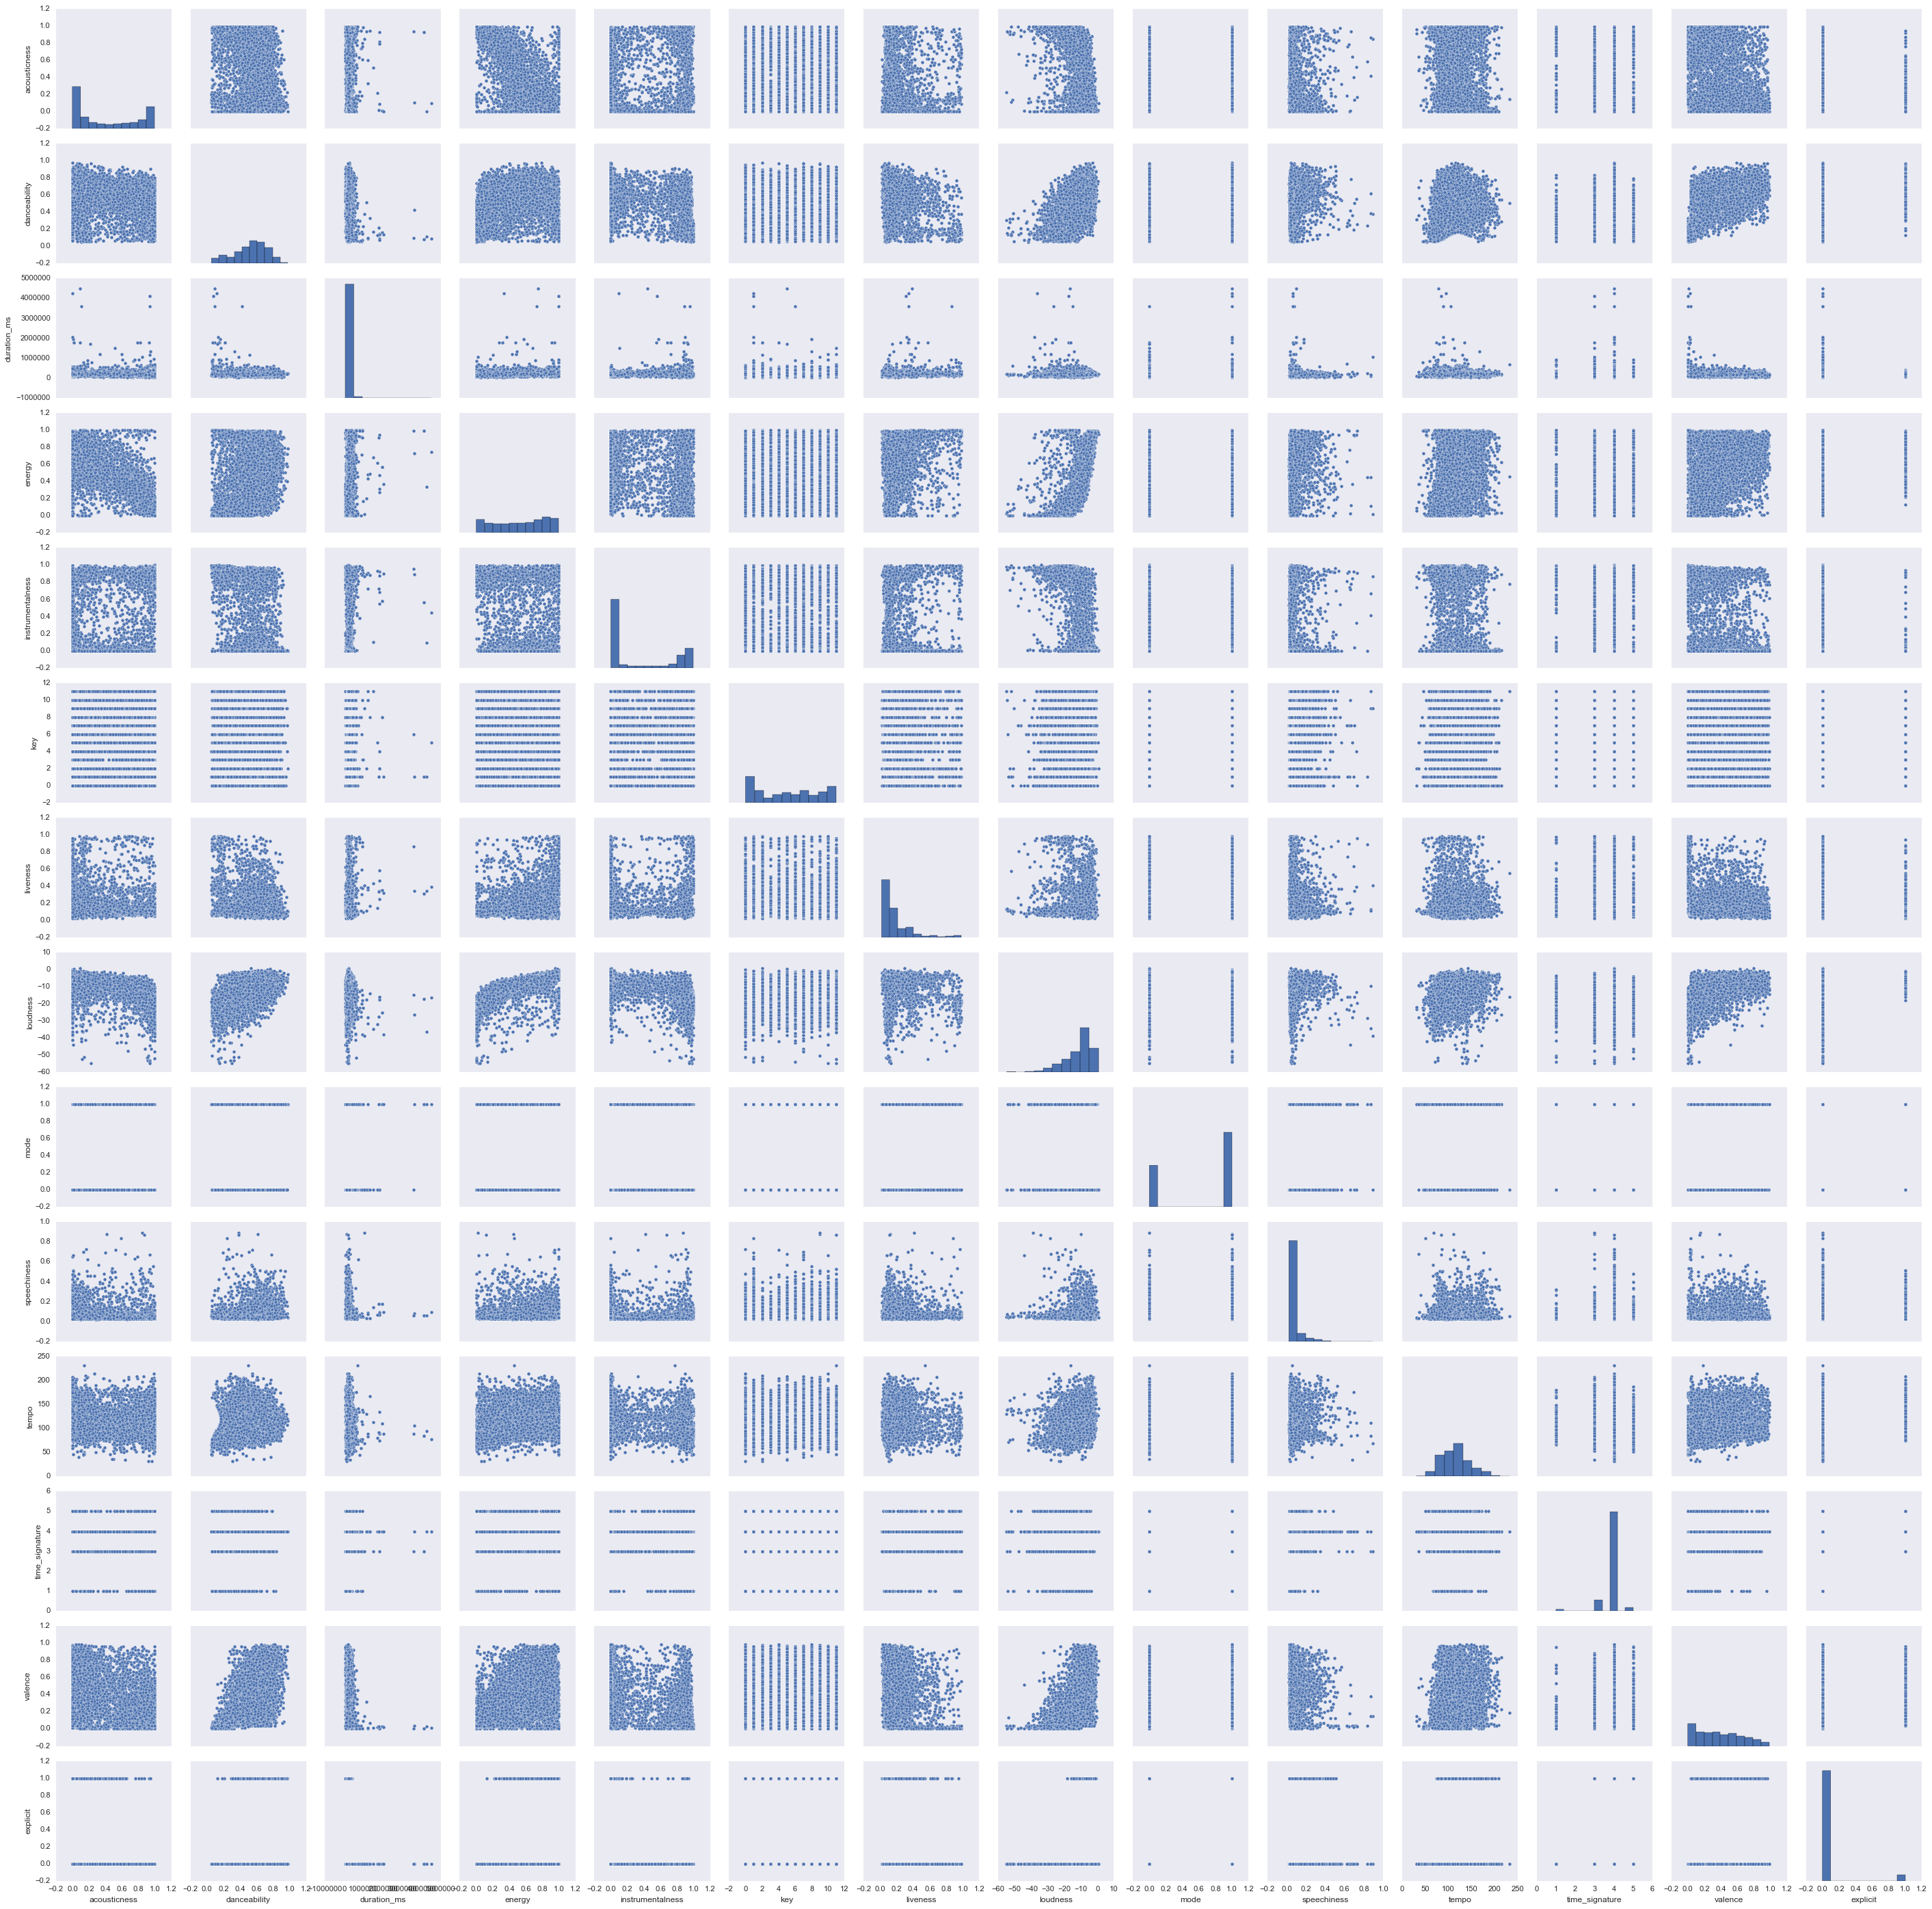

In [6]:
numeric_features = category_tracks_df.loc[:, category_tracks_df.dtypes != 'object']
sns.pairplot(numeric_features);

#### Each song category appears to over/under index on ceratin definitive attributes; for example, 'Party' songs are defined by higher levels of energy and danceability.  These distinctions can be leveraged in designing a machine learning classification approach to song categorization
- <font color='red'> Red is a _<80_ under-index compared to total </font>
- <font color='green'> Green is a _>120_ over-index compared to total </font>

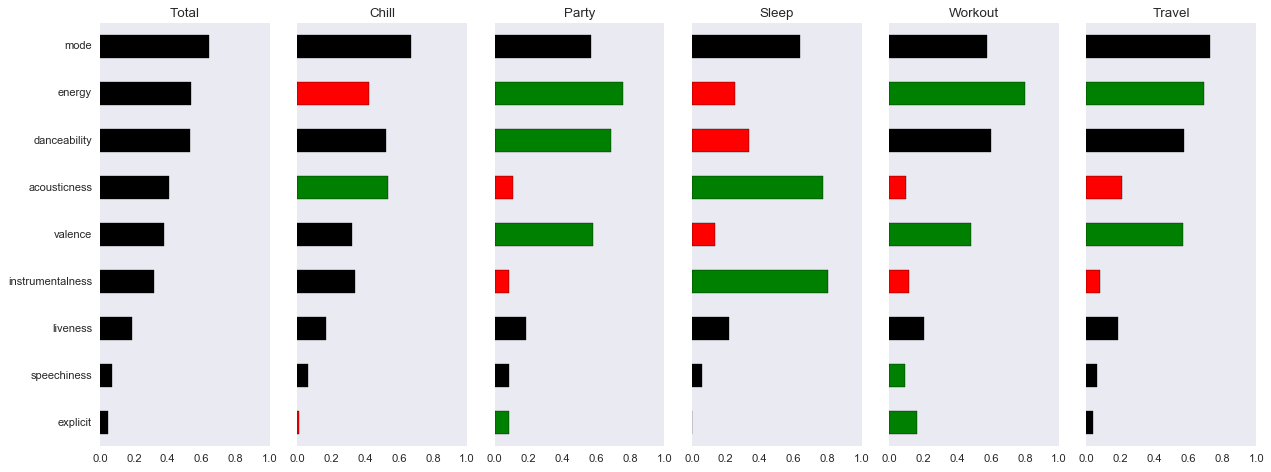

In [7]:
total_means = numeric_features.mean()
category_means = numeric_features.groupby(category_tracks_df['category']).mean()
fig, ax = plt.subplots(ncols=len(category_means)+1, nrows=1, figsize=(16,6))
profile_categories(total_means, category_means, ['Total', 'Chill', 'Party', 'Sleep', 'Workout', 'Travel'], ax)
fig.tight_layout()

#### For the purpose of this application, we will want to keep these categories separated as different options for users to select.  But, judging from the profiling, it seems that some categories are fairly related.  We can use clustering to further explore how the categories are statistically grouped together.
- Intuitively, it seems that two clusters around high and low 'energy' songs may surface
- Empirically, a two cluster solution results in one cluster containing nearly all of the workout and party songs, as expected, as well as travel songs.  The other cluster contains all sleep songs.  However, chill songs comprise a significant portion of each cluster, with a particularly large amount occuring in the 'party/workout' cluster.
- Perhaps the 'Chill' category is a little more diverse than the others. Its large size also means that it is the most strong in determining the total population averages, and most likely will present a challenge when trying to produce balanced model results

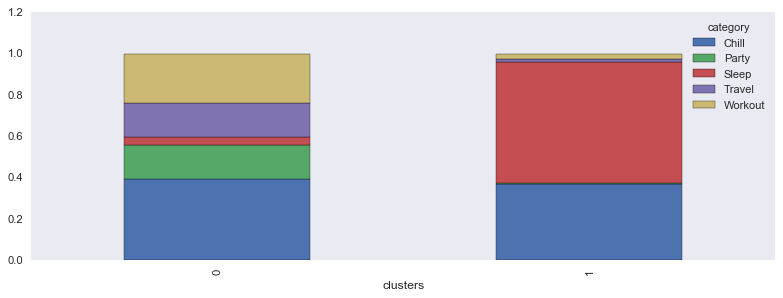

In [87]:
cluster_df = category_tracks_df.set_index(['category']).loc[:, category_tracks_df.dtypes != 'object']
# KMeans clustering is a distance based algorithm, and so is highly sensitive to metrics that inflate 
# distance measurements, so only pre-normalized metrics on a small scale are used for this exploration
cluster_df.drop(['duration_ms', 'key', 'mode', 'tempo', 'time_signature', 'explicit'], inplace=True, axis=1) 

kmeans = KMeans(n_clusters=2) 
kmeans.fit(cluster_df)

cluster_df['clusters'] = kmeans.labels_
results = cluster_df.groupby(['clusters', 'category']).size()
results.unstack().divide(results.unstack().sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(12, 4), legend=6);

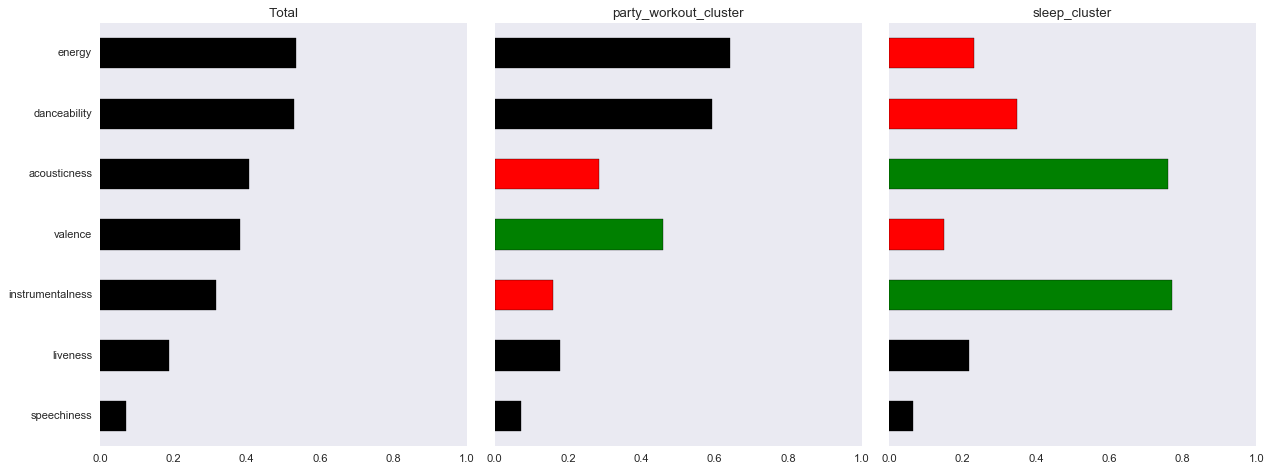

In [95]:
total_means = cluster_df.drop('clusters', axis=1).mean()
category_means = cluster_df.groupby(cluster_df['clusters'].map({0:'party_workout_cluster', 1:'sleep_cluster'})).mean()
fig, ax = plt.subplots(ncols=len(category_means)+1, nrows=1, figsize=(16,6))
profile_categories(total_means, category_means, ['Total', 'party_workout_cluster', 'sleep_cluster'], ax)
fig.tight_layout()